In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
files_dict = data.load_files_dict_single_site()

### Filter data for single-site analysis

In [ ]:
k = 'Atlanta'
# k = 'Columbus'
df = files_dict[k]
theme_index = np.where(
    np.array(list(map(str.lower, df.columns.values))) == 'theme')[0][0]
col_vals = df.columns[4: theme_index]

# separate into relevant pieces
qs = df['Subcategory']
responses_df = df[col_vals]
themes_df = df[df.columns[theme_index:]]

### Run sentiment

In [ ]:
sentiment_prompt = '''### You are given a question and a response. Rate the sentiment/supportiveness of the response on a scale of 1 to 5, where 1 is very negative and 5 is very positive. ###

Question: {question}

Response: {response}

Rating (1-5):'''

llm = imodelsx.llm.get_llm('gpt-4', repeat_delay=3)

num_questions = len(qs)
sentiments = defaultdict(list)
for question_num in tqdm(range(num_questions), position=0):
    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)
    for response_num in tqdm(range(len(responses)), position=1):
        response = responses.values[response_num]

        if pd.isna(response):
            sentiments[question_num].append(np.nan)
        else:
            prompt = sentiment_prompt.format(
                question=question.strip(), response=response.strip())
            sentiments[question_num].append(llm(prompt))

### Plot sentiment

/tmp/ipykernel_3917697/710176021.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_df['Value'][idxs] = sent_df['Value'][idxs].astype(float).round()


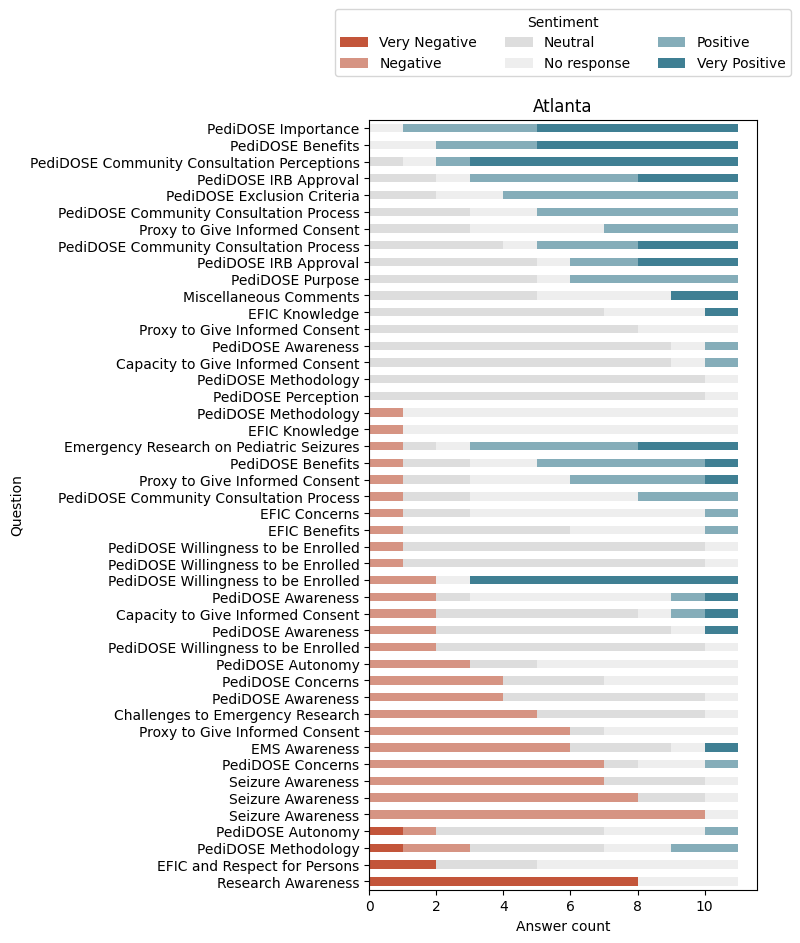

In [27]:
sent_df = pd.DataFrame([(key, var) for (key, L) in sentiments.items() for var in L],
                       columns=['Question', 'Value'])

# round  values
idxs = sent_df['Value'].notna()
sent_df['Value'][idxs] = sent_df['Value'][idxs].astype(float).round()
value_maps = {
    1: 'Very Negative',
    2: 'Negative',
    3: 'Neutral',
    4: 'Positive',
    5: 'Very Positive',
}
sent_df['Value'] = sent_df['Value'].map(value_maps.get)
sent_df['Value'] = sent_df['Value'].fillna('No response')

sent_df = sent_df.groupby(['Question', 'Value']).size().unstack(fill_value=0)
levels = ['Very Negative', 'Negative', 'Neutral',
          'No response', 'Positive', 'Very Positive']
sent_df = sent_df.reindex(levels, axis=1)
sent_df = sent_df.sort_values(by=levels, ascending=False)

# set colors
colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]
sent_df.plot(kind='barh', stacked=True, figsize=(5, 10), color=colors)

# add xticklabels
plt.yticks(range(46), labels=df['Domain'].values[sent_df.index.values])

# move legend to top
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=3, title='Sentiment')
plt.xlabel('Answer count')
plt.title(k)
plt.savefig('../figs/sentiment_example.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# no limit display
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(df[['Domain', 'Subcategory']])